In [18]:
import numpy as np
from docplex.mp.model import Model
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians
from collections import defaultdict
from qiskit import QuantumCircuit
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from scipy.optimize import minimize

backend = Aer.get_backend("qasm_simulator")

In [42]:
def Knapsack(values, weights, max_weight):
    mdl = Model("Knapsack")
    x = mdl.binary_var_list(len(values), name="x")
    mdl.minimize(-mdl.sum(var * values[i] for i, var in enumerate(x)))
    mdl.add_constraint(mdl.sum(var * weights[i] for i, var in enumerate(x)) <= max_weight)
    return mdl

def cost_kp(bitstring, list_values, list_weights):
    value = 0
    weight = 0
    for n, i in enumerate(bitstring):
        if i == "1":
            value += list_values[n]
            weight += list_weights[n]
    return value, weight

def objective_KP(samples_dict, problem_data):
    list_values =  problem_data["values"]
    list_weights =  problem_data["weights"]
    max_weight = problem_data["max_weights"]
    optimal_value, optimal_weight = cost_kp(problem_data["sol"], list_values, list_weights)
    optimal_ising_value, optimal_ising_weight = cost_kp(problem_data["sol_ising"], list_values, list_weights)
    results = []
    total_counts = 0
    probability = 0
    probability_ising = 0
    for bitstring, counts in samples_dict.items():
        value, weight = cost_kp(bitstring, list_values, list_weights)
        results.append([value, weight, counts, weight <= max_weight])
        if abs(value - optimal_value) < 1e-6 and abs(weight - optimal_weight) < 1e-6:
            probability += counts
        if abs(value - optimal_ising_value) < 1e-6 and abs(weight - optimal_ising_weight) < 1e-6:
            probability_ising += counts
        total_counts += counts
    probability /= total_counts
    probability_ising /= total_counts
    return {"results":np.array(results), "optimal":(optimal_value, optimal_weight), "optimal_ising":(optimal_ising_value, optimal_ising_weight), "probability":probability, "probability_ising":probability_ising}

def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc


In [3]:
problems = {}
np.random.seed(123)
lambdas = [0.9603,0.08] # From the paper the lambdas found: https://arxiv.org/abs/2211.13914    
# Random Cases with the following values for the problems:
values_lim = (5, 63) # Values of the items limits
weights_lim = (1, 20) # Weight of the items limits
nodes_list_qubo = range(10, 25)
num_random_cases = 10 # Number of random cases per problem size
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    problems[nodes] = defaultdict(dict)
    print(f"--------- {nodes} ------------")
    for kk in range(num_random_cases):
        values = np.random.randint(values_lim[0], values_lim[1], nodes) # Random items' values
        weights = np.random.randint(weights_lim[0], weights_lim[1], nodes) # Random items' weights
        problems[nodes][kk]["values"] = values
        problems[nodes][kk]["weights"] = weights
        problems[nodes][kk]["max_weights"] = int(np.sum(weights) * 0.5) # Maximum weight in the knapsack allowed
        mdl =  Knapsack(values, weights, problems[nodes][kk]["max_weights"])
        mdl.solve() # Solving the model using CPLEX: To find the optimal solution - The solution is guarantee to be the optimal by B&B
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars()) # The solution in binary

        qubo = FromDocplex2IsingModel(mdl, unbalanced_const=True, strength_ineq=lambdas) # Convert the CPLEX model into an Ising Hamiltonian model using the unbalanced penalization approach
        mdl_ising = qubo.qubo_docplex
        mdl_ising.solve() # Solve the new model to find the optimal solution of the Ising Hamiltonian
        problems[nodes][kk]["sol_ising"] = "".join(str(round(mdl_ising.solution.get_value(var))) for var in mdl_ising.iter_binary_vars()) # Optimal solution of the new Ising Hamiltonian (In an ideal case it must be the CPLEX solution found before but in practice it is a solution close to the optimal one in terms of the Hamming distance)
        ising_hamiltonian = qubo.ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        problems[nodes][kk]["hamiltonian"] = {tuple(t):w/max_w for t, w in zip(ising_hamiltonian.terms,ising_hamiltonian.weights) if abs(w) > 1e-10} # Ising Hamiltonian after a normalization 
np.save("./Data/KP/problems.npy", problems)

--------- 10 ------------
--------- 11 ------------
--------- 12 ------------
--------- 13 ------------
--------- 14 ------------
--------- 15 ------------
--------- 16 ------------
--------- 17 ------------
--------- 18 ------------
--------- 19 ------------
--------- 20 ------------
--------- 21 ------------
--------- 22 ------------
--------- 23 ------------
--------- 24 ------------


In [4]:
problems = np.load("./Data/KP/problems.npy", allow_pickle=True).item()

# Running QAOA circuits using p = Nq

In [5]:
shots = 1000
delta = 0.5
results = {}
for nodes in problems.keys():
    results[nodes] = defaultdict(dict)
    print(f"-------- nodes: {nodes} ----------")
    for kk in problems[nodes].keys():
        hamiltonian = problems[nodes][kk]["hamiltonian"]
        p = nodes
        gammas = np.arange(1, p+1) * delta/p # Annealing linear ramp schedule: cost hamiltonian term
        betas = np.arange(1, p+1)[::-1] * delta/p # Annealing linear ramp schedule: mixer term
        qc = qaoa_circ(hamiltonian, gammas, betas, nodes) # QAOA circuit
        solutions = backend.run(qc, shots=shots).result().get_counts() # Samples results
        results[nodes][kk]["samples"] = solutions


-------- nodes: 10 ----------
-------- nodes: 11 ----------
-------- nodes: 12 ----------
-------- nodes: 13 ----------
-------- nodes: 14 ----------
-------- nodes: 15 ----------
-------- nodes: 16 ----------
-------- nodes: 17 ----------
-------- nodes: 18 ----------
-------- nodes: 19 ----------
-------- nodes: 20 ----------
-------- nodes: 21 ----------
-------- nodes: 22 ----------
-------- nodes: 23 ----------
-------- nodes: 24 ----------


# Postprocessing: Cost function and constraints analysis

In [43]:
results = np.load("./Data/KP/results.npy", allow_pickle=True).item()
for nodes in problems.keys():
    print(f"-------- nodes: {nodes} ----------")
    for kk in problems[nodes].keys():
        samples = results[nodes][kk]["samples"]
        results[nodes][kk]["postprocessing"] = objective_KP(samples, problems[nodes][kk])
np.save("./Data/KP/results.npy", results)

-------- nodes: 10 ----------
-------- nodes: 11 ----------
-------- nodes: 12 ----------
-------- nodes: 13 ----------
-------- nodes: 14 ----------
-------- nodes: 15 ----------
-------- nodes: 16 ----------
-------- nodes: 17 ----------
-------- nodes: 18 ----------
-------- nodes: 19 ----------
-------- nodes: 20 ----------
-------- nodes: 21 ----------
-------- nodes: 22 ----------
-------- nodes: 23 ----------
-------- nodes: 24 ----------


Text(0.5, 1.0, 'Solutions found using LR-QAOA 1000 shots for 24 items and case 1')

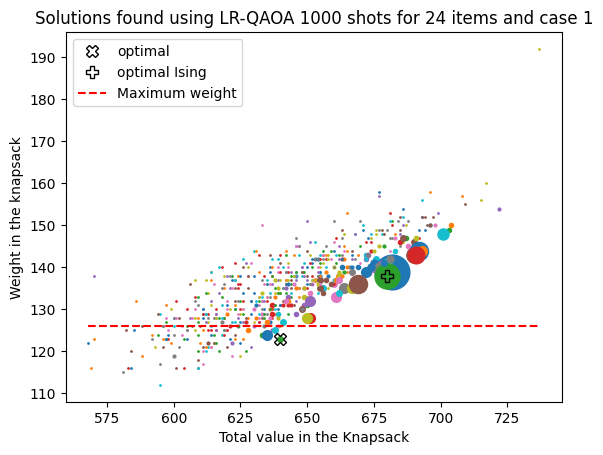

In [13]:
nodes = 24
case = 1
problems = np.load("./Data/KP/problems.npy", allow_pickle=True).item()
results = np.load("./Data/KP/results.npy", allow_pickle=True).item()

fig, ax = plt.subplots()
values = results[nodes][case]["postprocessing"]["results"][:,0]
weights = results[nodes][case]["postprocessing"]["results"][:,1]
counts = results[nodes][case]["postprocessing"]["results"][:,2]
max_weight = problems[nodes][case]["max_weights"]
for sample in results[nodes][case]["postprocessing"]["results"]:
    ax.plot(sample[0], sample[1], marker="o",linewidth=0, markersize=sample[2])

ax.plot(results[nodes][case]["postprocessing"]["optimal"][0], results[nodes][case]["postprocessing"]["optimal"][1], marker="X",linewidth=0, markersize=8, color="None", markeredgecolor="black", label="optimal")
ax.plot(results[nodes][case]["postprocessing"]["optimal_ising"][0], results[nodes][case]["postprocessing"]["optimal_ising"][1], marker="P",linewidth=0, markersize=8, color="None", markeredgecolor="black", label="optimal Ising")

ax.plot([min(values), max(values)], [max_weight, max_weight], linestyle="--", color="red", label="Maximum weight")

ax.set_xlabel("Total value in the Knapsack")
ax.set_ylabel("Weight in the knapsack")
ax.legend()
ax.set_title(f"Solutions found using LR-QAOA 1000 shots for {nodes} items and case {case}")

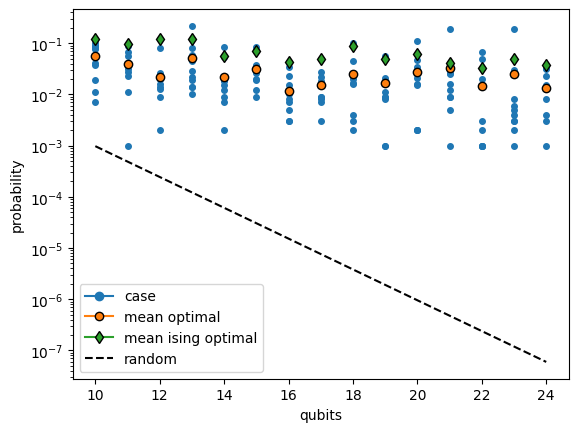

In [11]:
fig, ax = plt.subplots()
for nodes in problems.keys():
    prob = []
    prob_ising = []
    for kk in problems[nodes].keys():
        ax.plot(nodes, results[nodes][kk]["postprocessing"]["probability"], marker="o", color="tab:blue", markersize=4)
        prob.append(results[nodes][kk]["postprocessing"]["probability"])
        prob_ising.append(results[nodes][kk]["postprocessing"]["probability_ising"])
    ax.plot(nodes, np.mean(prob), color="tab:orange", markeredgecolor="black", marker="o")
    ax.plot(nodes, np.mean(prob_ising), color="tab:green", markeredgecolor="black", marker="d")
ax.plot([],[], marker="o", color="tab:blue", label="case")
ax.plot([],[], marker="o", color="tab:orange", label="mean optimal", markeredgecolor="black")
ax.plot([], [], color="tab:green", markeredgecolor="black", marker="d", label="mean ising optimal")
ax.plot(np.arange(10, 25), [1/2**(i) for i in np.arange(10, 25)], color="black", linestyle="--",label="random")

ax.set_yscale("log")
ax.set_ylabel("probability")
ax.set_xlabel("qubits")
ax.legend()

# Strategy to find optimal  Lagrange multipliers of the unbalanced penalization function using LR-QAOA 

In [182]:
def run_qaoa(lambdas, mdl, delta, shots):
    nodes = mdl.number_of_binary_variables
    qubo = FromDocplex2IsingModel(mdl, unbalanced_const=True, strength_ineq=lambdas) # Convert the CPLEX model into an Ising Hamiltonian model using the unbalanced penalization approach
    ising_hamiltonian = qubo.ising_model
    max_w = np.max(np.abs(ising_hamiltonian.weights))
    hamiltonian_dict = {tuple(t):w/max_w for t, w in zip(ising_hamiltonian.terms,ising_hamiltonian.weights) if abs(w) > 1e-10} # Ising Hamiltonian after a normalization 
    gammas = np.arange(1, p+1) * delta/p # Annealing linear ramp schedule: cost hamiltonian term
    betas = np.arange(1, p+1)[::-1] * delta/p # Annealing linear ramp schedule: mixer term
    qc = qaoa_circ(hamiltonian_dict, gammas, betas, nodes) # QAOA circuit
    samples = backend.run(qc, shots=shots).result().get_counts() # Samples results
    return samples

def objective_func_lambdas(lambdas, mdl, problem, delta, shots):
    samples = run_qaoa(lambdas, mdl, delta, shots)
    results = objective_KP(samples, problem)["results"]
    samples_satisfy_constraint = np.mean(results[:,2] * results[:,3]) # Maximize the samples that satisfy the constraints
    values = np.mean(results[:,0] * results[:,2] * results[:,3]) # Maximize the value of the solutions that satisfy the constraint 
    print(f"values: {round(values,2)} | constraints satified:{round(samples_satisfy_constraint,2)} | lambdas: {np.round(lambdas,3)}")
    return -(values + 10*samples_satisfy_constraint)

In [197]:
problems = np.load("./Data/KP/problems.npy", allow_pickle=True).item()
lambdas0 = [1, 0.2]
nodes = 12
case = 0
shots = 1000
delta = 0.5
mdl = Knapsack(problems[nodes][case]["values"], problems[nodes][case]["weights"], problems[nodes][kk]["max_weights"])
sol = minimize(objective_func_lambdas, x0=lambdas0, args=(mdl, problems[nodes][case], delta, shots), method="COBYLA",options={"maxiter":20})
lambda_opt = sol.x
samples_opt = run_qaoa(lambda_opt, mdl, delta, shots)
results_opt = objective_KP(samples_opt, problems[nodes][case])

values: 311.68 | constraints satified:1.31 | lambdas: [1.  0.2]
values: 487.96 | constraints satified:2.07 | lambdas: [2.  0.2]
values: 57.82 | constraints satified:0.34 | lambdas: [2.  1.2]
values: 151.06 | constraints satified:11.39 | lambdas: [ 2.38 -0.72]
values: 159.33 | constraints satified:11.04 | lambdas: [ 2.19 -0.26]
values: 792.12 | constraints satified:3.28 | lambdas: [1.75 0.15]
values: 720.29 | constraints satified:2.96 | lambdas: [1.5  0.15]
values: 181.6 | constraints satified:0.8 | lambdas: [1.73 0.28]
values: 124.12 | constraints satified:18.0 | lambdas: [ 1.74 -0.1 ]
values: 238.55 | constraints satified:1.04 | lambdas: [1.68 0.25]
values: 1771.05 | constraints satified:7.19 | lambdas: [1.75 0.09]
values: 1914.27 | constraints satified:7.78 | lambdas: [1.71 0.04]
values: 1752.19 | constraints satified:7.28 | lambdas: [ 1.76 -0.  ]
values: 2219.94 | constraints satified:9.03 | lambdas: [1.68 0.04]
values: 1804.18 | constraints satified:7.32 | lambdas: [1.65 0.06]
valu

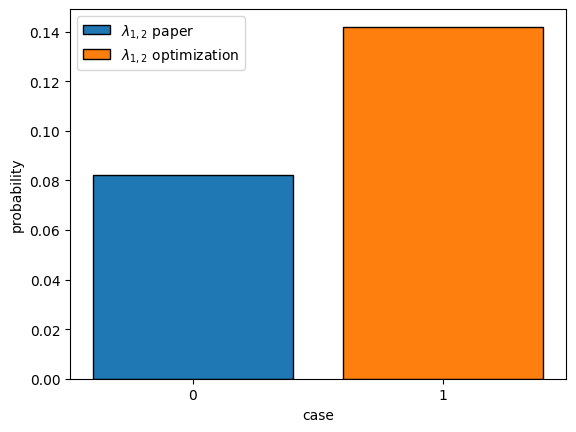

In [202]:
results = np.load("./Data/KP/results.npy", allow_pickle=True).item()
fig, ax = plt.subplots()
ax.bar(0, results[nodes][case]["postprocessing"]["probability"], label=r"$\lambda_{1,2}$ paper", edgecolor="black")
ax.bar(1, results_opt["probability"], label=r"$\lambda_{1,2}$ optimization", edgecolor="black")
ax.set_ylabel("probability")
ax.set_xlabel("case")
ax.set_xticks([0,1])
ax.legend()

Text(0.5, 1.0, 'Solutions found using LR-QAOA 1000 shots for 12 items and case 0')

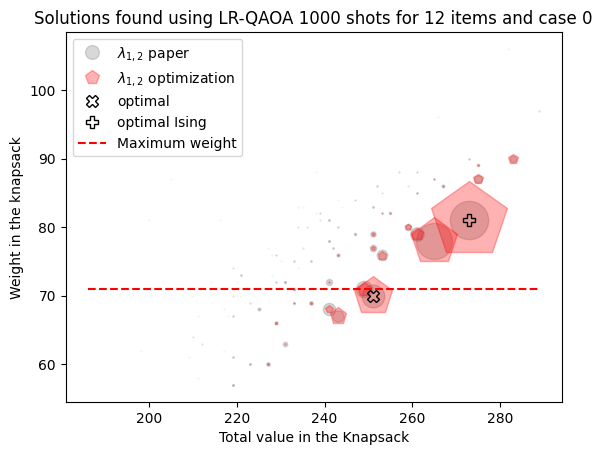

In [201]:
problems = np.load("./Data/KP/problems.npy", allow_pickle=True).item()
results = np.load("./Data/KP/results.npy", allow_pickle=True).item()

fig, ax = plt.subplots()
values = results[nodes][case]["postprocessing"]["results"][:,0]
weights = results[nodes][case]["postprocessing"]["results"][:,1]
counts = results[nodes][case]["postprocessing"]["results"][:,2]
max_weight = problems[nodes][case]["max_weights"]
for sample in results[nodes][case]["postprocessing"]["results"]:
    ax.plot(sample[0], sample[1], marker="o",linewidth=0, markersize=sample[2]/5, color="grey", alpha=0.3)
for sample in results_opt["results"]:
    ax.plot(sample[0], sample[1], marker="p",linewidth=0, markersize=sample[2]/5, color="red", alpha=0.3)

ax.plot([], [], marker="o",linewidth=0, markersize=10, color="grey", alpha=0.3, label=r"$\lambda_{1,2}$ paper")
ax.plot([], [], marker="p",linewidth=0, markersize=10, color="red", alpha=0.3, label=r"$\lambda_{1,2}$ optimization")

ax.plot(results[nodes][case]["postprocessing"]["optimal"][0], results[nodes][case]["postprocessing"]["optimal"][1], marker="X",linewidth=0, markersize=8, color="None", markeredgecolor="black", label="optimal")
ax.plot(results[nodes][case]["postprocessing"]["optimal_ising"][0], results[nodes][case]["postprocessing"]["optimal_ising"][1], marker="P",linewidth=0, markersize=8, color="None", markeredgecolor="black", label="optimal Ising")

ax.plot([min(values), max(values)], [max_weight, max_weight], linestyle="--", color="red", label="Maximum weight")

ax.set_xlabel("Total value in the Knapsack")
ax.set_ylabel("Weight in the knapsack")
ax.legend()
ax.set_title(f"Solutions found using LR-QAOA 1000 shots for {nodes} items and case {case}")